In [1]:
# import internal files
from historymatch import emulators
from historymatch import sample
from historymatch import historymatch
from historymatch import plot
from historymatch import utils


# import external modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import pandas as pd
#import importlib
from matplotlib.patches import Rectangle

import sklearn.linear_model as skl

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

In [2]:
# import data

with open("data/MassEval2016.dat",'r') as infile:
    Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11,12),
              names=('N', 'Z', 'A', 'Element', 'Ebinding', 'E_unc'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=64,
              index_col=False)
    
# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding'] = pd.to_numeric(Masses['Ebinding'], errors='coerce')
Masses = Masses.dropna()
Masses['E_unc'] = pd.to_numeric(Masses['E_unc'], errors='coerce')
Masses = Masses.dropna()
# Convert from keV to MeV.
Masses['Ebinding'] /= 1000
Masses['E_unc'] /= 1000

# Group the DataFrame by nucleon number, A.
Masses = Masses.groupby('A')
# Find the rows of the grouped DataFrame with the maximum binding energy.
Masses = Masses.apply(lambda t: t[t.Ebinding==t.Ebinding.max()])

A0 = Masses['A'].to_numpy()
Z0 = Masses['Z'].to_numpy()
N0 = Masses['N'].to_numpy()
Element = Masses['Element'].to_numpy()
Energies = Masses['Ebinding'].to_numpy()

#Energies_unc = Masses['E_unc'].to_numpy()
Energies_unc = Masses['E_unc'].to_numpy()

In [3]:
# define parameter space


a0_lim = np.array([4,8]).reshape(1,-1)
a1_lim = np.array([0, 1.1]).reshape(1,-1)
a2_lim = np.array([-0.4, 0.1]).reshape(1,-1)
a3_lim = np.array([-0.01, 0.015]).reshape(1,-1)
a4_lim = np.array([-0.1, 0.4]).reshape(1,-1)
a5_lim = np.array([-0.1, 0.4]).reshape(1,-1)

#[ 5.73205069 -0.15849126  0.73057298  0.00661303  0.21505478  0.12058198]

a_limits = np.concatenate((a0_lim, a1_lim, \
                            a2_lim, a3_lim, a4_lim, a5_lim), axis=0)

theta_0_vals = np.linspace(a_limits[0,0], a_limits[0,1], 100)
theta_1_vals = np.linspace(a_limits[1,0], a_limits[1,1], 100)
theta_2_vals = np.linspace(a_limits[2,0], a_limits[2,1], 100)

#theta_0_bound = np.array([4, 8]).reshape(1,-1)
#theta_1_bound = np.array([-0.4, 0]).reshape(1,-1)
#theta_2_bound = np.array([0.4, 0.7]).reshape(1,-1)
#theta_3_bound = np.array([-0.005, 0.015]).reshape(1,-1) # keep
#theta_4_bound = np.array([-0.1, 0.4]).reshape(1,-1)
#theta_5_bound = np.array([-0.1, 0.4]).reshape(1,-1)


theta_0_bound = np.array([0, 15]).reshape(1,-1)
theta_1_bound = np.array([-2, 2]).reshape(1,-1)
theta_2_bound = np.array([-2, 2]).reshape(1,-1)
theta_3_bound = np.array([-0.1, 0.1]).reshape(1,-1) # keep
theta_4_bound = np.array([-1, 1]).reshape(1,-1)
theta_5_bound = np.array([-1, 1]).reshape(1,-1)


parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, \
                                   theta_2_bound, theta_3_bound, theta_4_bound, theta_5_bound), axis=0)


theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)


In [4]:
def LiquidDropModel4d(a0, a1, a2, a3, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0))

def LiquidDropModel5d(a0, a1, a2, a3, a4, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A

def LiquidDropModel6d(a0, a1, a2, a3, a4, a5, A, Z, N):
    
    return a0 + a1*A + a2*(A**(2.0/3.0)) + a3*Z*(Z-1)*(A**(-1.0/3.0)) \
            + a4*((N-Z)**2)/A + a5*( (-1)**Z + (-1)**N )*(0.5*A**(-0.5))

In [5]:
# generate observational data with some uncertainty

start = 30
step = 3
stop = 240

obs_data = Energies[start:stop:step]
sigma_obs = Energies_unc[start:stop:step]
A = A0[start:stop:step]
Z = Z0[start:stop:step]
N = N0[start:stop:step]


variables = np.concatenate((A.reshape(-1,1),Z.reshape(-1,1),\
                            N.reshape(-1,1)), axis=1)

print(obs_data.shape)

(70,)


In [6]:
indep_var = [1, A, (A**(2.0/3.0)), Z*(Z-1)*(A**(-1.0/3.0)), \
                 ((N-Z)**2)/A, ( (-1)**Z + (-1)**N )*(0.5*A**(-0.5))]

def design_matrix(ndim):
    # design matrix X
    X = np.zeros((len(A),ndim))
    for i in range(ndim):
        X[:,i] = indep_var[i]
    return X

In [7]:

clf = skl.LinearRegression(fit_intercept=False).fit(design_matrix(6), obs_data)

print(clf.coef_)

preds = clf.predict(design_matrix(6))


err = np.sum(np.square(obs_data-preds))

pred_sigma = np.sqrt(err / (len(obs_data) - 5)) 

#https://stats.stackexchange.com/questions/284772/estimator-of-variance-of-error
#sigma_model = [3*pred_sigma,2*pred_sigma,pred_sigma]

sigma_model  = np.zeros((len(A)))
for i in range(len(A)):
    if A[i] < 40:
        sigma_model[i] = 0.997
        
    elif A[i] < 140:
        sigma_model[i] = 0.136
    elif A[i] < 200:
        sigma_model[i] = 0.072
    else:
        sigma_model[i] = 0.018
        
print(sigma_model)


[ 6.25757161e+00 -1.23776008e-01  5.84031989e-01  4.74106010e-03
  1.58915921e-01  1.01318864e-01]
[0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136
 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136
 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.136 0.072 0.072
 0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.072 0.072
 0.072 0.072 0.072 0.072 0.072 0.072 0.018 0.018 0.018 0.018 0.018 0.018
 0.018 0.018 0.018 0.018 0.018 0.018 0.018 0.018 0.018 0.018]


In [8]:
volshapes = ['ellipsoid', 'hypercube']

In [9]:
nwaves = 3
ndim = 6
nsamples = 2 * (10**5)
volshape = 'ellipsoid'

In [10]:
#importlib.reload(historymatch)

# initialise history matching class
HM = historymatch.HistoryMatch(ndim, 'GP', volshape, nsamples=nsamples, ntraining=200)

In [11]:


ToyModel = historymatch.Simulator(HM)
ToyModel.set_simulator(LiquidDropModel6d)

#obs_data[start:stop:step]

HM.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, outputs_per_wave = [10,25,40])
HM.initialize_volume(parameter_bounds[:,0], parameter_bounds[:,1])

results = HM.run(nwaves=nwaves)

Number of Samples : 200000
(200, 6)
Running wave 1


 20%|██        | 2/10 [00:20<01:19,  9.89s/it] /Users/elliemay/miniconda3/envs/tif320/lib/python3.9/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/elliemay/miniconda3/envs/tif320/lib/python3.9/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/elliemay/miniconda3/envs/tif320/lib/python3.9/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
100%|██████████| 10/10 [01:32<00:00,  9.29s/it]


[8 9 8 ... 8 8 8]
Number of Non-Implausible Samples : (22, 7)
[[ 0.0688125 14.9228625]
 [-0.47471    0.39063  ]
 [-1.60105    1.59229  ]
 [-0.0579745  0.0674975]
 [-0.917195   0.853025 ]
 [-0.825375   0.868485 ]]
Convergence : True
Relative nonimplausible volume remaining: 0.08
Running wave 2


100%|██████████| 25/25 [03:51<00:00,  9.27s/it]


[22 23 20 ... 19 23 23]
Number of Non-Implausible Samples : (16290, 7)
[[-4.39027291 19.28977931]
 [-0.90399087  0.84567339]
 [-3.31457043  3.74947798]
 [-0.06133819  0.05451222]
 [-1.87529988  1.40353585]
 [-1.95118297  2.09919848]]
Convergence : False
Relative nonimplausible volume remaining: 2.345
Running wave 3


100%|██████████| 40/40 [06:16<00:00,  9.40s/it]


[34 34 35 ... 35 36 39]
Number of Non-Implausible Samples : (16945, 7)
[[-5.51250744 19.02728353]
 [-1.05006131  0.87758309]
 [-3.23927857  4.24687464]
 [-0.06137441  0.06340502]
 [-1.58594621  1.49584778]
 [-1.7752726   1.81808956]]
Convergence : False
Relative nonimplausible volume remaining: 2.549


In [12]:
#volshape2 = 'hypercube'
#HM2 = historymatch.HistoryMatch(ndim, 'GP', volshape2, nsamples=nsamples)

In [13]:
#ToyModel2 = historymatch.Simulator(HM2)
#ToyModel2.set_simulator(LiquidDropModel5d)

#HM2.set_observations(obs_data, variables=variables, sigma_obs=sigma_obs, sigma_model=sigma_model, outputs_per_wave = [6])
#HM2.initialize_volume(a_limits[:,0], a_limits[:,1])

#results2 = HM2.run(nwaves=nwaves)

In [14]:
analytic_mean = np.loadtxt("data/6D_analytic_mean.txt").reshape(ndim,)
analytic_cov = np.loadtxt("data/6D_analytic_cov.txt").reshape(ndim,ndim)

OSError: data/6D_analytic_mean.txt not found.

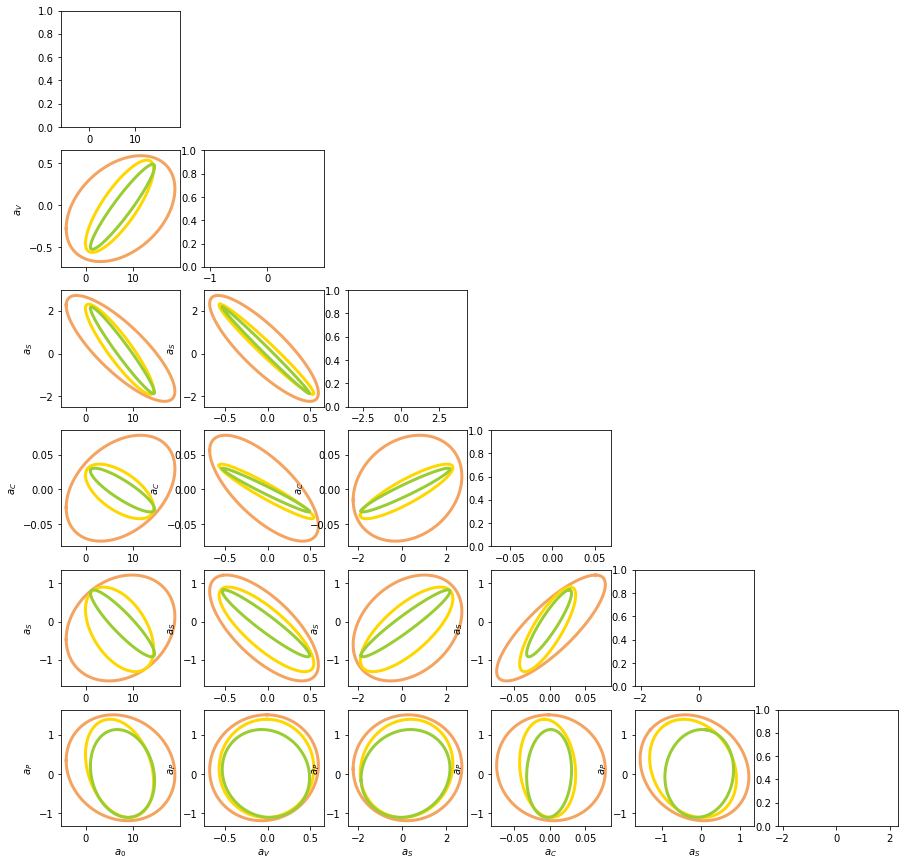

In [15]:
#importlib.reload(plot)

colors = ['sandybrown', 'gold', 'yellowgreen', 'mediumseagreen', 'turquoise', 'cornflowerblue', 'mediumpurple', 'plum', 'lightpink', ]
theta_names = [r'$a_{0}$', r'$a_{V}$', r'$a_{S}$', r'$a_{C}$', r'$a_{S}$', r'$a_{P}$']

sample_bounds = utils.locate_boundaries(results.samples[-1], ndim)
tempbounds = np.concatenate((sample_bounds[-1].reshape(-1,1),sample_bounds[-1].reshape(-1,1)),axis=1).T

true = clf.coef_
#true = [15.92808016, -18.53454643,  -0.72795844, -23.73239355,]

fig, axes = plt.subplots(ndim, ndim, figsize=(15,15))
if volshape == 'ellipsoid':
    for k in range(nwaves):
        
        nonimplausible_scaled = np.zeros_like(results.nonimplausible[k])
        for dim in range(ndim):
            nonimplausible_scaled[:,dim] = results.nonimplausible[k][:,dim]
        mean = np.mean(nonimplausible_scaled[:,:-1].T, axis=1)
        cov = np.cov(nonimplausible_scaled[:,:-1].T)
        
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    #true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    cov_matrix = np.array([[cov[i,i], cov[i,j]],[cov[j,i], cov[j,j]]])
                    plot.get_cov_ellipse(cov_matrix, [mean[i],mean[j]], 3, 5.991, ax, colors[k])
                    #plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    
                    #ax.scatter(results.samples[1][:,i], results.samples[1][:,j], color=colors[4])
                    #ax.scatter(results.nonimplausible[0][:,i], results.nonimplausible[0][:,j], color=colors[0])
                    #ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    #ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    #ax.scatter(true[i],true[j])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                elif i == j:
                    #ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], mean[i], np.sqrt(cov[i,i])), color='plum')
                    ax.set_xlim([sample_bounds[i][0],sample_bounds[i][1]])
                    #ax.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.axis('off')
elif volshape == 'hypercube':
    for k in range(nwaves):
        nonimplausible = np.zeros_like(results.nonimp_bounds[k])
        for dim in range(ndim):
            nonimplausible[dim] = results.nonimp_bounds[k][dim]
            
        for i in range(ndim):
            for j in range(ndim):
                ax = axes[j,i]
                if i < j:
                    true_cov = np.array([[analytic_cov[i,i], analytic_cov[i,j]],[analytic_cov[j,i], analytic_cov[j,j]]])
                    ax.add_patch(Rectangle((nonimplausible[i,0], nonimplausible[j,0]),\
                                           (nonimplausible[i,1]-nonimplausible[i,0]), \
                                           (nonimplausible[j,1]-nonimplausible[j,0]),\
                        color=colors[k],alpha=0.7,label='Nonimp. Hypercube'))
                    plot.get_cov_ellipse(true_cov, [analytic_mean[i],analytic_mean[j]], 3, 5.991, ax, 'black')
                    ax.set_xlim([parameter_bounds[i][0],parameter_bounds[i][1]])
                    ax.set_ylim([parameter_bounds[j][0],parameter_bounds[j][1]])
                    ax.set_xlabel(theta_names[i])
                    ax.set_ylabel(theta_names[j])
                else:
                    ax.axis('off')

In [ ]:
'''fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

#ax.scatter(samples_scaled[:,0], samples_scaled[:,1], samples_scaled[:,2], s=10, color='gold', alpha=0.1, label='Nonimplausible Samples')
ax.scatter(nonimplausible_scaled[:,0], nonimplausible_scaled[:,1], nonimplausible_scaled[:,2], s=20, color='red', label='Nonimplausible Samples')
ax.scatter(true[0],true[1],true[2])
#ax.view_init(0, 90)'''

In [ ]:
dictionary = {'Nsamples : ' : len(results.samples[0]), 'Noutputs : ' : len(obs_data), 'Output First : ' : start, 'Output Last : ' : stop}

keys = np.array(['Nsamples', 'Noutputs', 'StartZ', 'EndZ']).reshape(1,-1)
vals = np.array([len(results.samples[0]), len(obs_data), start, stop]).reshape(1,-1)

In [ ]:
'''shape = volshape
for wave in range(nwaves):
    file = open("data/{}D_HM_w{}_{}_nonimp_noem.txt".format(ndim,wave,shape), "w")
    np.savetxt(file, results.nonimplausible[wave])
    file.close()
    file3 = open("data/{}D_HM_w{}_{}_samples_noem.txt".format(ndim,wave,shape), "w")
    np.savetxt(file3, results.I_samples[wave])
    file3.close()
    file2 = open("data/{}D_HM_details_{}_noem.txt".format(ndim,wave,shape), "w")
    np.savetxt(file2, keys, fmt="%s")
    np.savetxt(file2, vals, fmt="%d")
    file2.close()'''
    '''else:
        for wave in range(nwaves):
            file = open("data/{}D_HM_w{}_{}_nonimp.txt".format(ndim,wave,shape), "w")
            np.savetxt(file, results2.nonimplausible[wave])
            file.close()
            file3 = open("data/{}D_HM_w{}_{}_samples.txt".format(ndim,wave,shape), "w")
            np.savetxt(file3, results2.I_samples[wave])
            file3.close()
            file2 = open("data/{}D_HM_details_{}.txt".format(ndim,wave,shape), "w")
            np.savetxt(file2, keys, fmt="%s")
            np.savetxt(file2, vals, fmt="%d")
            file2.close()'''